In [81]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import os
from pathlib import Path 
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage, TextArea
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from scipy.stats import pearsonr

In [82]:
train_features = "/home/ruijingyang/cytotox/eda_phase/lbp_experiments/train_features/compound_features"
label_mapping = "/home/ruijingyang/cytotox/eda_phase/lbp_experiments/label_mapping_all.csv"
testing_features = "/home/ruijingyang/cytotox/eda_phase/lbp_experiments/test_features/compound_features"
compound_label_map = pd.read_csv(label_mapping, index_col=None)
compound_label_map.head()

,Unnamed: 0,Object Id,Interpretation,label
0,0,ORM-0364078,non-toxic,non-toxic
1,1,ORM-0364078,non-toxic,non-toxic
2,2,ORM-0364074,non-toxic,non-toxic
3,3,ORM-0364074,non-toxic,non-toxic
4,4,ORM-0049279,"cytotoxic, mitotoxic",toxic


In [83]:
compound_label_map.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
compound_label_map

,index,Object Id,Interpretation,label
0,0,ORM-0364078,non-toxic,non-toxic
1,1,ORM-0364078,non-toxic,non-toxic
2,2,ORM-0364074,non-toxic,non-toxic
3,3,ORM-0364074,non-toxic,non-toxic
4,4,ORM-0049279,"cytotoxic, mitotoxic",toxic
5,5,ORM-0049279,"cytotoxic, mitotoxic",toxic
6,6,ORM-0120988,"cytotoxic, mitotoxic",toxic
7,7,ORM-0120988,"cytotoxic, mitotoxic",toxic
8,8,ORM-0140940,"cytotoxic, non-mitotoxic",toxic
9,9,ORM-0140940,"cytotoxic, non-mitotoxic",toxic


In [84]:
compound_label_map[compound_label_map['index']==(24 - 1)]['label'].values[0] == 'toxic'

True

### load and prepare data for training

In [85]:
def prep_data_label(compound_list, feature_path):
    all_features = []
    all_labels = []

    for file_name in compound_list:
        file_path = os.path.join(feature_path, file_name)
        features = np.load(file_path)
        all_features.append(features)
        
        # get corresponding label
        compound_ind = file_name[9:11]
        # print(compound_ind)
        compound_label = 1 if compound_label_map[compound_label_map['index']==(int(compound_ind) - 1)]['label'].values[0] == 'toxic' else 0
        # print(f"compound index: {compound_ind}, label: {compound_label}")
        all_labels.append(compound_label)
        

    combined_features = np.vstack(all_features)


    print(combined_features.shape)
    # print(all_labels)
    return combined_features, all_labels

In [86]:
features_view1, labels_view1 = prep_data_label(sorted(os.listdir(train_features)), train_features)


(24, 800)


In [87]:
features_view1[0]

array([1.91469479e-02, 3.34705075e-02, 6.37431413e-03, 5.68561385e-02,
       8.51929012e-02, 1.05432099e-01, 1.17986968e-02, 5.17558299e-02,
       5.62060185e-01, 6.79123800e-02, 2.34430727e-02, 4.12637174e-02,
       1.43604252e-03, 4.21750686e-02, 7.43912894e-03, 8.94641632e-02,
       4.55418381e-03, 5.84267833e-02, 6.41062243e-01, 9.07355967e-02,
       1.70713306e-02, 3.14300412e-02, 2.18278464e-03, 3.71802126e-02,
       1.38271605e-02, 7.73465364e-02, 6.31087106e-03, 4.54672497e-02,
       7.04837106e-01, 6.43467078e-02, 2.30298354e-02, 3.93964335e-02,
       8.57338820e-07, 2.50265775e-02, 2.57201646e-06, 6.59550754e-02,
       4.28669410e-06, 4.18947188e-02, 7.10734739e-01, 9.39549040e-02,
       4.97933813e-02, 6.80101166e-02, 3.03455075e-02, 9.04149520e-02,
       1.31465192e-01, 1.16179698e-01, 6.33333333e-02, 8.83573388e-02,
       2.03931756e-01, 1.58168724e-01, 2.08942044e-02, 3.71382030e-02,
       8.97633745e-03, 6.43741427e-02, 9.04749657e-02, 1.13277606e-01,
      

In [88]:
features_view2, labels_view2 = prep_data_label(sorted(os.listdir(testing_features)), testing_features)

(24, 800)


In [89]:
features_view2[0]

array([2.09525034e-02, 3.67121056e-02, 8.49965706e-03, 6.23045267e-02,
       8.54715364e-02, 1.12680041e-01, 1.53360768e-02, 5.62062757e-02,
       5.29306413e-01, 7.25308642e-02, 2.44727366e-02, 4.34447874e-02,
       2.96124829e-03, 4.43621399e-02, 1.17378258e-02, 8.76911866e-02,
       7.85665295e-03, 5.77872085e-02, 6.33799726e-01, 8.58864883e-02,
       1.73885460e-02, 3.32741770e-02, 2.92609739e-03, 4.13331619e-02,
       1.61359739e-02, 8.00737311e-02, 8.90432099e-03, 4.55418381e-02,
       6.89753086e-01, 6.46690672e-02, 2.19804527e-02, 3.72445130e-02,
       0.00000000e+00, 2.39197531e-02, 0.00000000e+00, 6.98293896e-02,
       0.00000000e+00, 4.64343278e-02, 7.10191187e-01, 9.04003772e-02,
       4.79912551e-02, 6.64583333e-02, 3.69204390e-02, 9.78472222e-02,
       1.42477709e-01, 1.25795610e-01, 6.82175926e-02, 8.46450617e-02,
       1.80649005e-01, 1.48997771e-01, 2.02906379e-02, 3.70087449e-02,
       9.02349108e-03, 6.47076475e-02, 9.26586077e-02, 1.14446159e-01,
      

### 2 view's similarity

In [90]:
cos_similarities = [cosine_similarity([features_view1[i]], [features_view2[i]])[0][0] for i in range(24)]
euclidean_dists = [distance.euclidean(features_view1[i], features_view2[i]) for i in range(24)]
pearson_corrs = [pearsonr(features_view1[i], features_view2[i])[0] for i in range(24)]


avg_cos_similarity = np.mean(cos_similarities)
avg_euclidean_dist = np.mean(euclidean_dists)
avg_pearson_corr = np.mean(pearson_corrs)

print(f'Average Cosine Similarity: {avg_cos_similarity:.3f}')
print(f'Average Euclidean Distance: {avg_euclidean_dist:.3f}')
print(f'Average Pearson Correlation: {avg_pearson_corr:.3f}')

Average Cosine Similarity: 0.994
Average Euclidean Distance: 0.562
Average Pearson Correlation: 0.992


### Stratify train test data

In [91]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [92]:
def preprocessing(features, labels):
    all_features = np.array(features)
    all_labels = np.array(labels)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(all_features)
    return features_scaled, all_labels
    

In [93]:
features_scaled_view1, labels_view1 = preprocessing(features_view1, labels_view1)
features_scaled_view2, labels_view2 = preprocessing(features_view2, labels_view2)

In [94]:
# 划分训练和测试数据集
# X_train, X_test, y_train, y_test = train_test_split(features_scaled, all_labels, test_size=0.5, random_state=42)

In [95]:
X_train, X_test, y_train, y_test = features_scaled_view1, features_scaled_view2, labels_view1, labels_view2

In [96]:
X_train.shape

(24, 800)

In [97]:
X_test.shape

(24, 800)

In [98]:
# 创建和训练模型
lr_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)


# 评估模型
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.96
Confusion Matrix:
[[ 7  1]
 [ 0 16]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.94      1.00      0.97        16

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24



In [99]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练模型
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88
Confusion Matrix:
[[ 7  1]
 [ 2 14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.93      0.88      0.90        16

    accuracy                           0.88        24
   macro avg       0.86      0.88      0.86        24
weighted avg       0.88      0.88      0.88        24



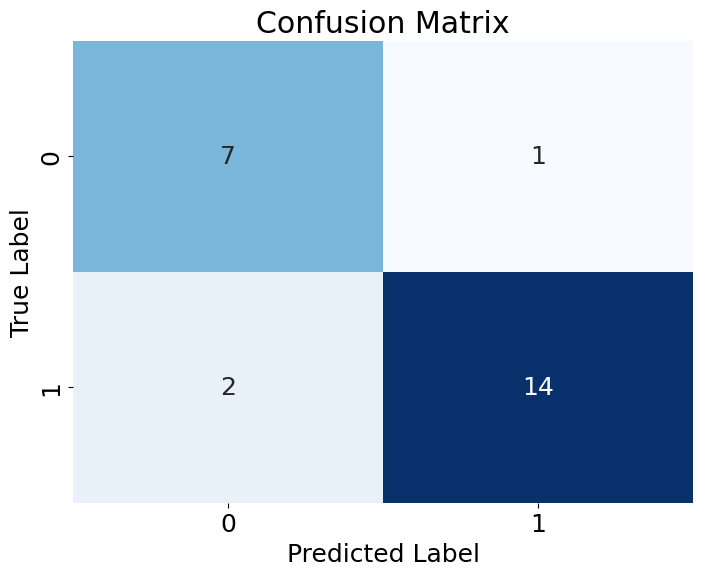

In [100]:
# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [101]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [102]:
# k = 3 

# # 创建K-means聚类模型
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(features_scaled_view1)

# # 获取聚类标签
# labels = kmeans.labels_

In [103]:
# pca = PCA(n_components=10)
# features_pca = pca.fit_transform(features_scaled_view1)

# # 绘制聚类结果
# plt.figure(figsize=(12, 10))
# sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=labels, style=labels, palette='viridis', s=100)

# # 添加索引或类别标签
# for i, text in enumerate(labels_view1):  # 也可以使用range(len(features))获取索引
#     show_text = f"cp{i+1}_{text}"
#     plt.annotate(show_text, (features_pca[i, 0], features_pca[i, 1]))

# plt.title('PCA of Clustering Results with Annotations')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.show()

In [104]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

In [105]:
def kmeans_visualization(k, features, labels_view, save_name):
    # kmeans = KMeans(n_clusters=k, random_state=42)
    # kmeans.fit(features)

    # labels = kmeans.labels_
    
    # PCA
    pca = PCA(n_components=10)
    features_pca = pca.fit_transform(features)

  
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=labels_view, style=labels_view, palette='viridis', s=200)

    for i, text in enumerate(labels_view):  
        show_text = f"cp{i+1}_{text}"
        plt.annotate(show_text, (features_pca[i, 0], features_pca[i, 1]))

    plt.title('PCA of Clustering Results with Annotations')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Label')
    plt.savefig(save_name + '.png')
    plt.show()
    

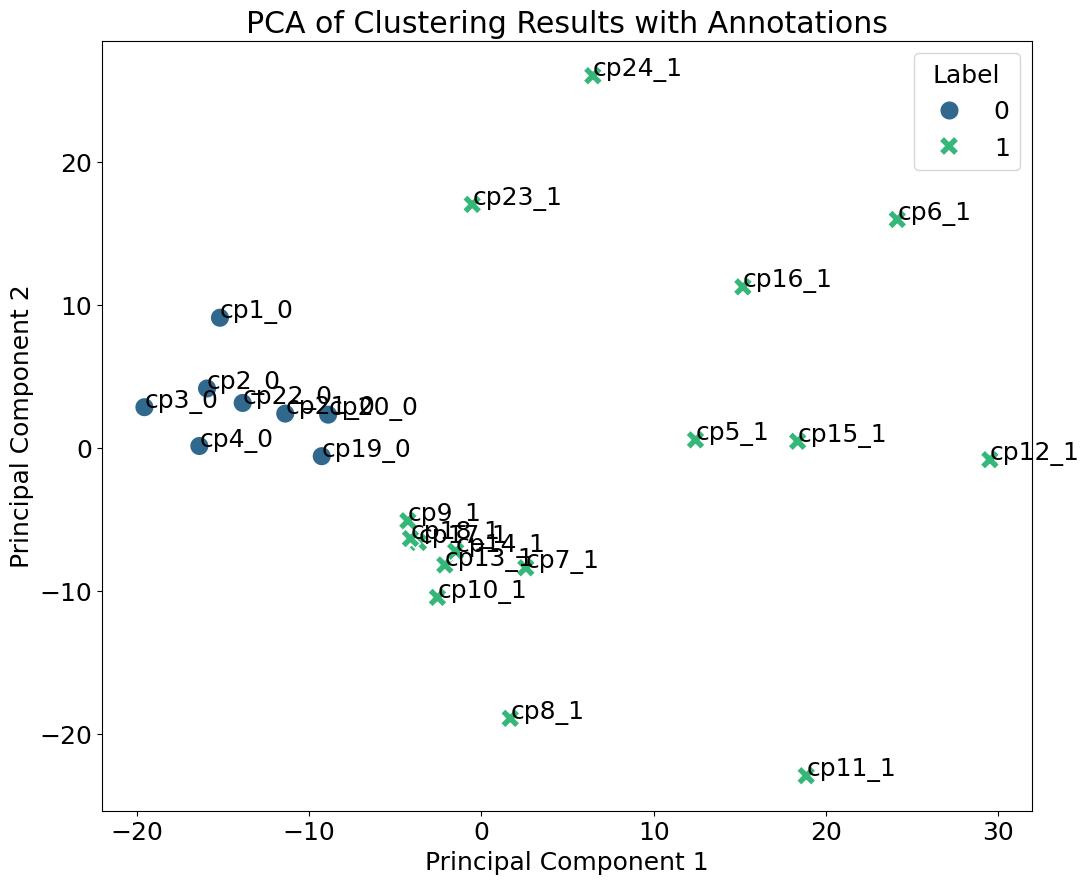

In [106]:
kmeans_visualization(2, features_scaled_view1, labels_view1, 'cluster_view1_k2')

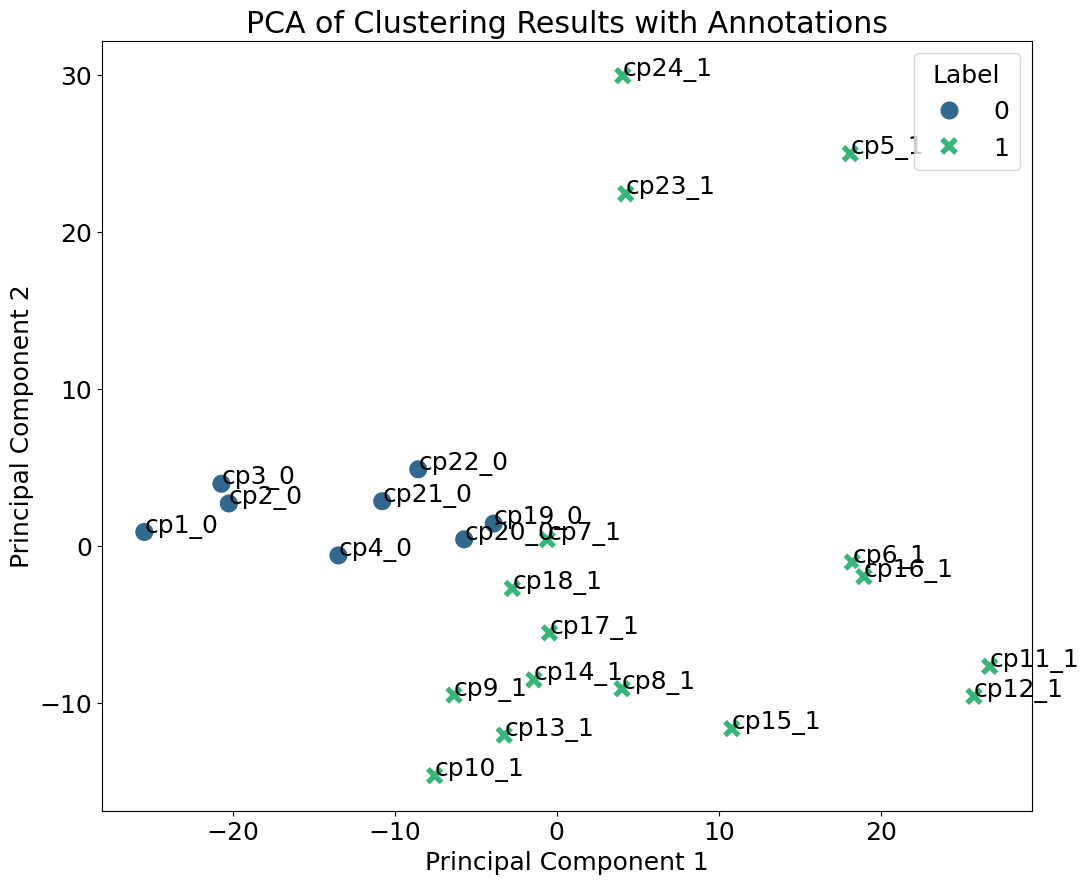

In [107]:
kmeans_visualization(2, features_scaled_view2, labels_view2, 'cluster_view2_k2')

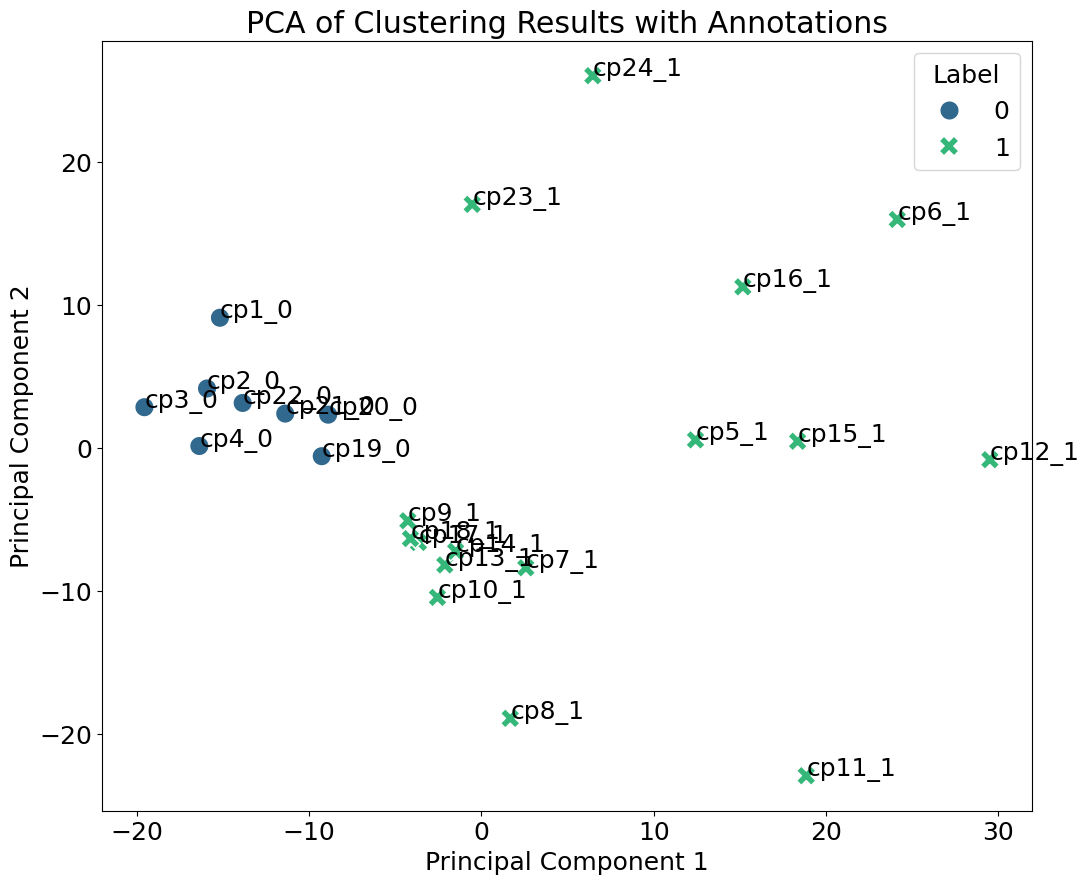

In [108]:
kmeans_visualization(3, features_scaled_view1, labels_view1, 'cluster_view1_k3')

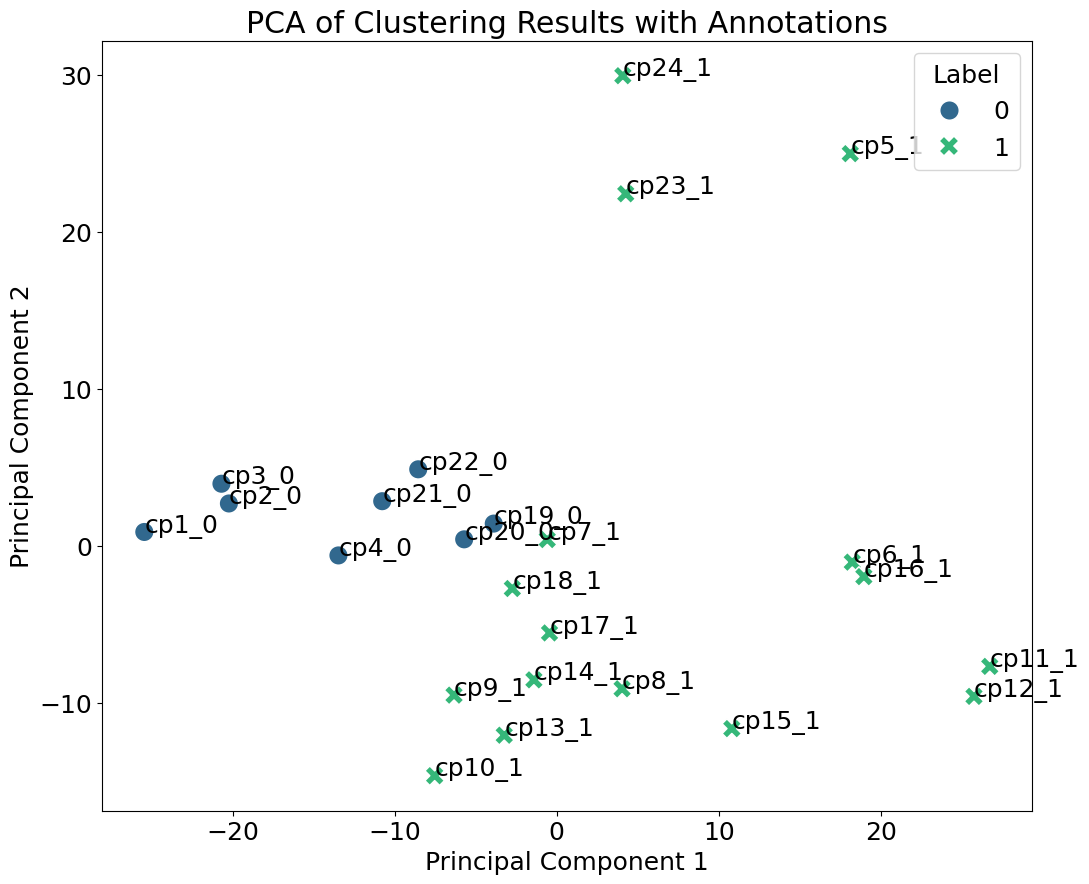

In [109]:
kmeans_visualization(3, features_scaled_view2, labels_view2, 'cluster_view2_k3')

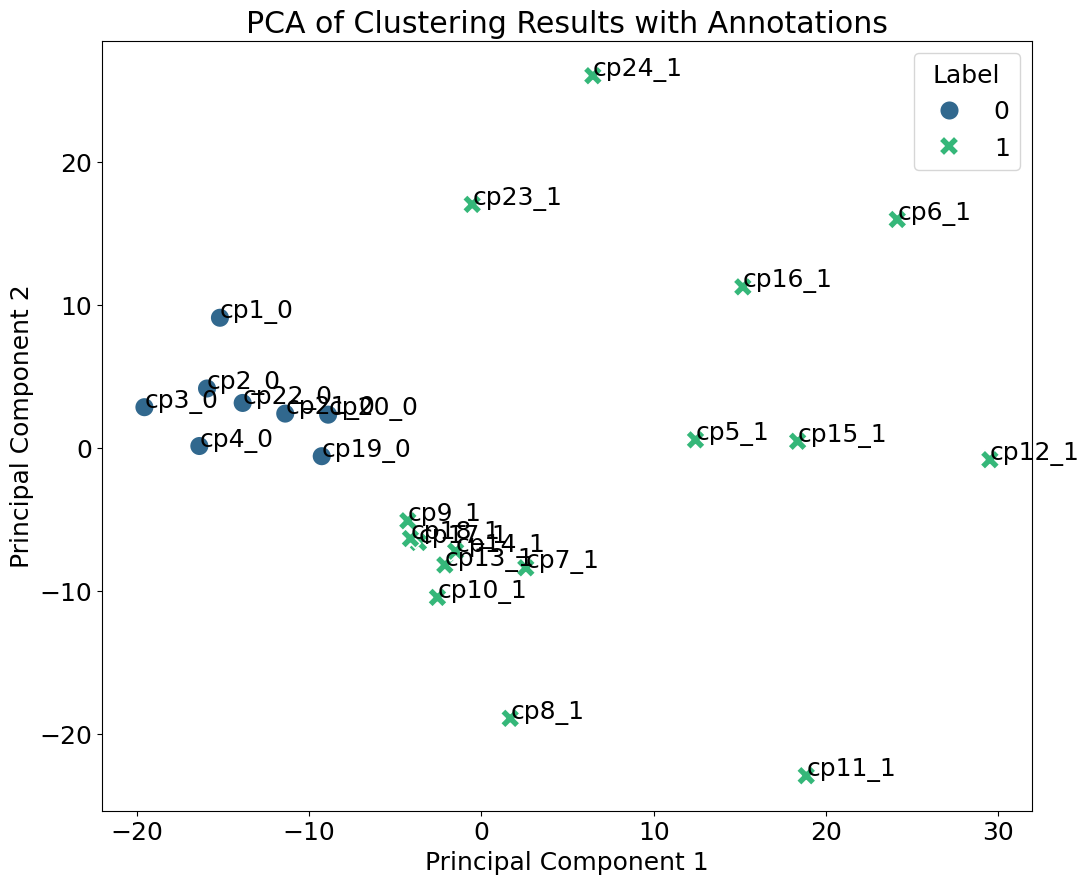

In [110]:
kmeans_visualization(4, features_scaled_view1, labels_view1, 'cluster_view1_k4')

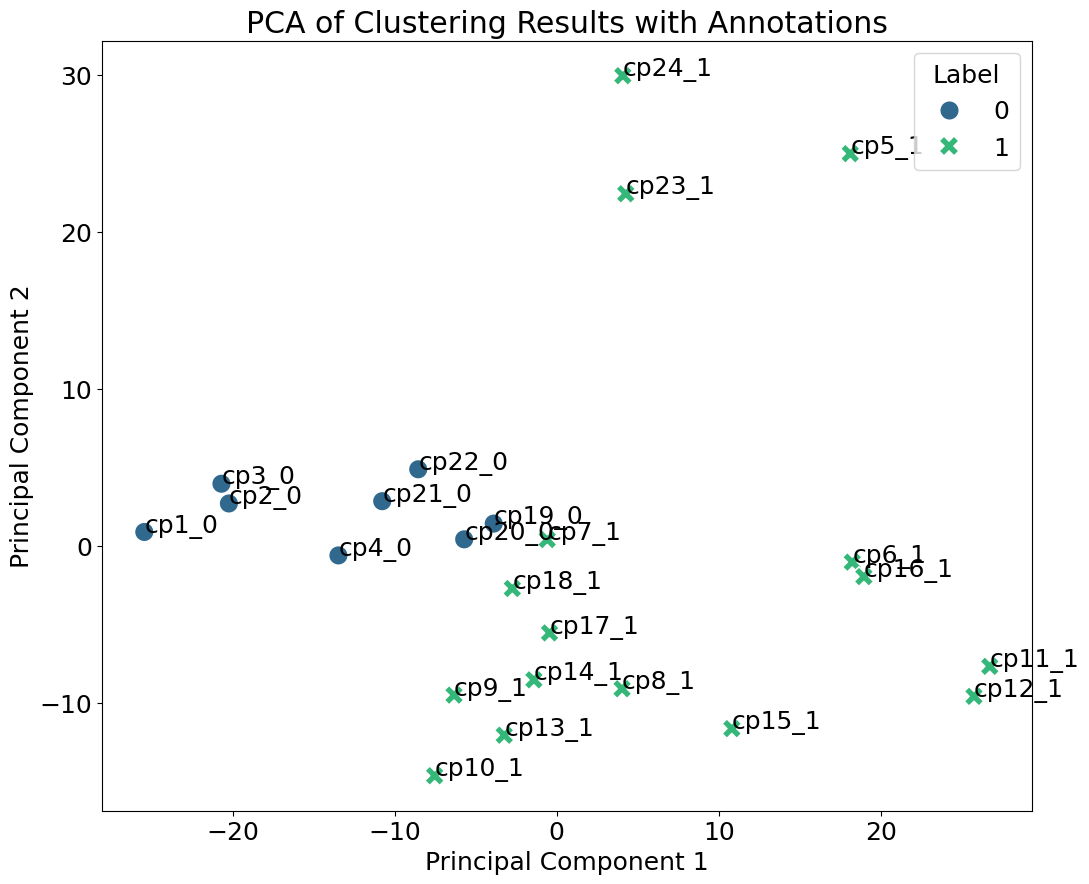

In [111]:
kmeans_visualization(4, features_scaled_view2, labels_view2, 'cluster_view2_k4')

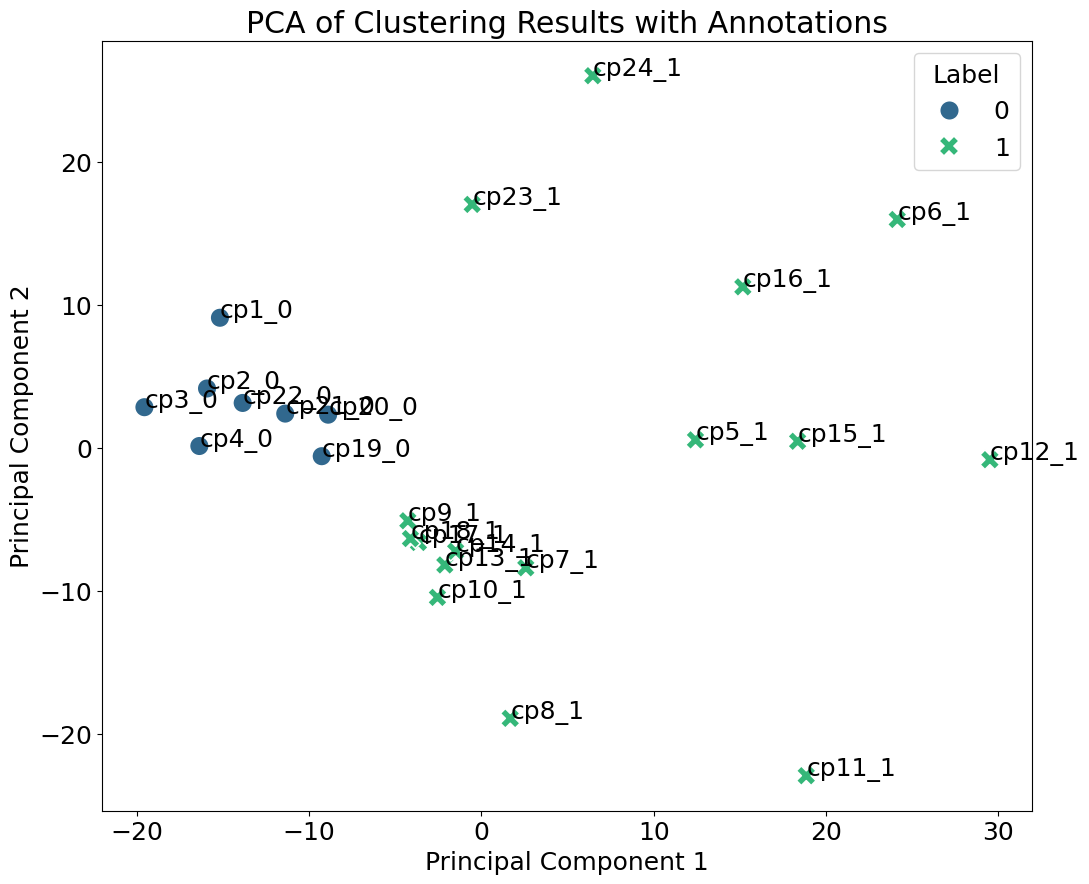

In [112]:
kmeans_visualization(5, features_scaled_view1, labels_view1, 'cluster_view1_k5')

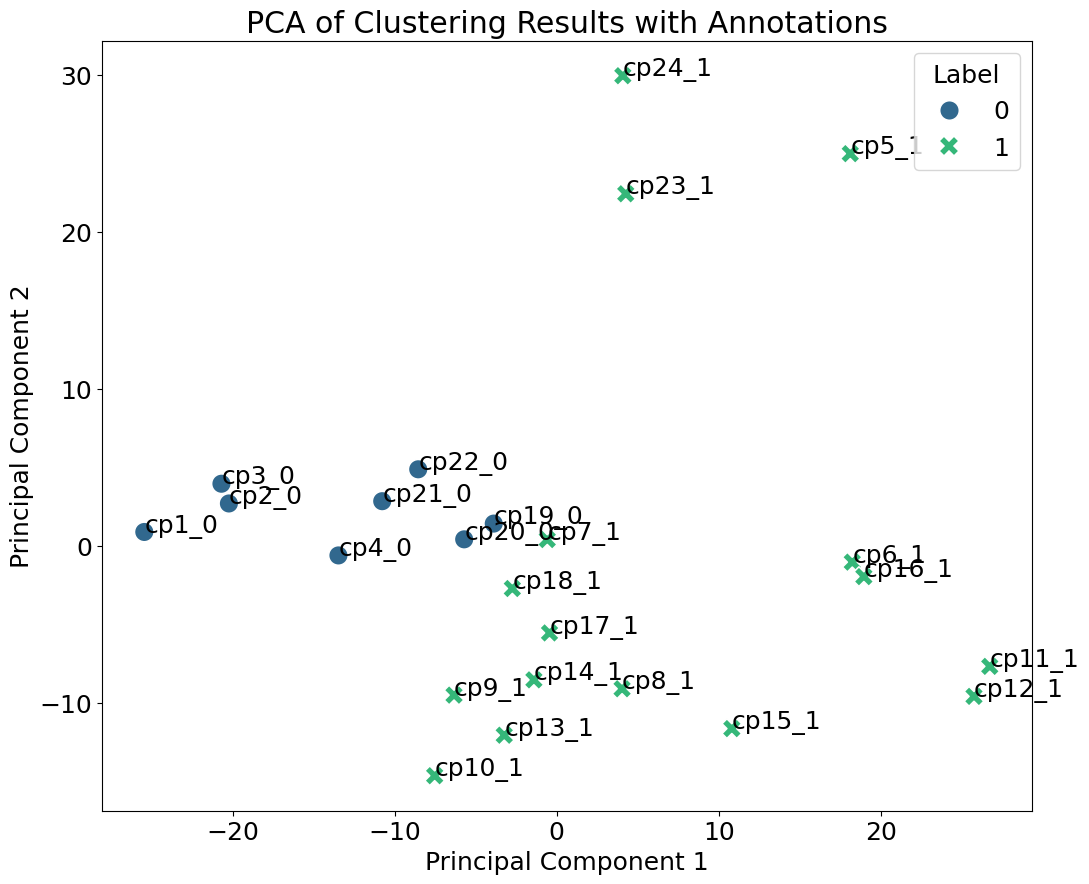

In [113]:
kmeans_visualization(5, features_scaled_view2, labels_view2, 'cluster_view2_k5')

### visualize feature distance

In [114]:
# num_feature_dimensions=10

# pca = PCA(n_components = num_feature_dimensions)
# pca.fit(feature_list)

# feature_list_compressed = pca.transform(feature_list)

# selected_features = feature_list_compressed
# selected_filenames = [os.path.join(file_path, f) for f in file_names]
# perplexity_value = len(features_np) // 2 
# tsne_results = TSNE(n_components=2,perplexity=perplexity_value,verbose=1,metric='euclidean').fit_transform(selected_features)

In [115]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        label = Path(image_path).stem[:6]+ '-'+ Path(image_path).stem[-1]
        # print(label)
        image.thumbnail((300, 300), Image.LANCZOS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        
        axis.add_artist(anno_box)
        # Add a text annotation for each image
        axis.annotate(label, (x0, y0 + 3), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [116]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(28, 28, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.6, axis=axis)
    plt.tight_layout()
    plt.savefig('visual_on_Arow.png', dpi=300)
    plt.show()

In [117]:
# show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

### cluster using numeric features

In [118]:
results_path = '/home/ruijingyang/cytotox/eda_phase/data/Cytotox_HCA_065_20230907_B0_results.csv'
results_info = pd.read_csv(results_path, encoding='latin1')
results_info

,Object Id,Highest Tested Concentration uM,Lowest Precipitated Concentration uM,Cell count IC50 uM,Cell count LEC uM,Nucleus Intensity EC50 uM,Nucleus Intensity LEC uM,Nucleus Area IC50 uM,Nucleus Area LEC uM,Plasma membrane permeability EC50 uM,PMP LEC uM,Lysosomal activity EC50 uM,Lysosomal activity LEC uM,MitoArea EC50 uM,MitoArea LEC uM,MMP EC50 uM,MMP LEC uM,Interpretation
0,ORM-0364078,200,-,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,non-toxic
1,ORM-0364074,200,-,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,>200,non-toxic
2,ORM-0049279,200,-,30.6,26.7,42.3,26.7,26.3,20.06,41.8,35.6,>200,47.5,26.3,26.7,>200,63.3,"cytotoxic, mitotoxic"
3,ORM-0120988,200,-,82.4,47.5,95.8,84.4,77.8,63.3,154.3,113,>200,26.7,75.6,63.3,>200,20.06,"cytotoxic, mitotoxic"
4,ORM-0140940,200,-,>200,>200,>200,200,>200,200,>200,>200,>200,150,>200,>200,>200,>200,"cytotoxic, non-mitotoxic"
5,ORM-0140942,200,-,35.8,26.7,52.2,26.7,25.1,20.06,48.9,35.6,4.4,5.015,36.6,26.7,56,63.3,"cytotoxic, mitotoxic"
6,ORM-0149820,200,200,>150,20.06,>150,>150,>150,>150,>150,>150,>150,1.254,>150,>150,8.3,10.03,"cytotoxic, mitotoxic"
7,ORM-0178130,200,-,55.4,47.5,67.7,20.06,34,20.06,75.9,47.5,6,2.508,58.9,47.5,9.2,10.03,"cytotoxic, mitotoxic"
8,ORM-0226420,100,-,>100,>100,>100,>100,>100,56.3,>100,>100,>100,13.4,>100,13.4,>100,>100,mildly affects cell health
9,DMSO,>200,-,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,>>200,non-toxic


In [122]:
label_column = []
# column = {}
for interpret in results_info["Interpretation"].tolist():
    if "non-toxic" in interpret:
        label_column.append(0)
    else:
        label_column.append(1)

In [123]:
# Remove the first and last column
results_info = results_info.drop(results_info.columns[2], axis=1)
data_clustering = results_info.iloc[:, 1:-1]

# Replace '>200' and '-' with a numeric value, here we use 200 for simplicity
data_clustering.replace(to_replace=[r'>200'], value=300, regex=True, inplace=True)
data_clustering.replace(to_replace=[r'>>200'], value=500, regex=True, inplace=True)
# data_clustering.replace(to_replace=[r'-'], value=200, regex=True, inplace=True)
data_clustering.replace(to_replace=[r'>100'], value=150, regex=True, inplace=True)
data_clustering.replace(to_replace=[r'>150'], value=180, regex=True, inplace=True)


# Convert all columns to numeric
data_clustering = data_clustering.apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values if present
data_clustering.dropna(inplace=True)

# Display the processed data
data_clustering.head()

/var/tmp/ipykernel_8915/694229589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering.replace(to_replace=[r'>200'], value=300, regex=True, inplace=True)
/var/tmp/ipykernel_8915/694229589.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering.replace(to_replace=[r'>>200'], value=500, regex=True, inplace=True)
/var/tmp/ipykernel_8915/694229589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clusterin

,Highest Tested Concentration uM,Cell count LEC uM,Nucleus Intensity EC50 uM,Nucleus Intensity LEC uM,Nucleus Area IC50 uM,Nucleus Area LEC uM,Plasma membrane permeability EC50 uM,PMP LEC uM,Lysosomal activity EC50 uM,Lysosomal activity LEC uM,MitoArea EC50 uM,MitoArea LEC uM,MMP EC50 uM,MMP LEC uM
0,200,300.0,300.0,300.0,300.0,300.00,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.00
1,200,300.0,300.0,300.0,300.0,300.00,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.00
2,200,26.7,42.3,26.7,26.3,20.06,41.8,35.6,300.0,47.5,26.3,26.7,300.0,63.30
3,200,47.5,95.8,84.4,77.8,63.30,154.3,113.0,300.0,26.7,75.6,63.3,300.0,20.06
4,200,300.0,300.0,200.0,300.0,200.00,300.0,300.0,300.0,150.0,300.0,300.0,300.0,300.00


In [120]:
len(data_clustering)

10

In [125]:
results_info['label'] = label_column

In [126]:
results_info

,Object Id,Highest Tested Concentration uM,Cell count LEC uM,Nucleus Intensity EC50 uM,Nucleus Intensity LEC uM,Nucleus Area IC50 uM,Nucleus Area LEC uM,Plasma membrane permeability EC50 uM,PMP LEC uM,Lysosomal activity EC50 uM,Lysosomal activity LEC uM,MitoArea EC50 uM,MitoArea LEC uM,MMP EC50 uM,MMP LEC uM,Interpretation,label
0,ORM-0364078,200,300,300,300,300,300,300,300,300,300,300,300,300,300,non-toxic,0
1,ORM-0364074,200,300,300,300,300,300,300,300,300,300,300,300,300,300,non-toxic,0
2,ORM-0049279,200,26.7,42.3,26.7,26.3,20.06,41.8,35.6,300,47.5,26.3,26.7,300,63.3,"cytotoxic, mitotoxic",1
3,ORM-0120988,200,47.5,95.8,84.4,77.8,63.3,154.3,113,300,26.7,75.6,63.3,300,20.06,"cytotoxic, mitotoxic",1
4,ORM-0140940,200,300,300,200,300,200,300,300,300,150,300,300,300,300,"cytotoxic, non-mitotoxic",1
5,ORM-0140942,200,26.7,52.2,26.7,25.1,20.06,48.9,35.6,4.4,5.015,36.6,26.7,56,63.3,"cytotoxic, mitotoxic",1
6,ORM-0149820,200,20.06,>150,>150,>150,>150,>150,>150,>150,1.254,>150,>150,8.3,10.03,"cytotoxic, mitotoxic",1
7,ORM-0178130,200,47.5,67.7,20.06,34,20.06,75.9,47.5,6,2.508,58.9,47.5,9.2,10.03,"cytotoxic, mitotoxic",1
8,ORM-0226420,100,>100,>100,>100,>100,56.3,>100,>100,>100,13.4,>100,13.4,>100,>100,mildly affects cell health,1
9,DMSO,300,300,300,300,300,300,300,300,300,300,300,300,300,300,non-toxic,0


In [ ]:
# Perform K-means clustering for 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
clusters_2 = kmeans_2.fit_predict(data_clustering)
kmeans_2.fit(data_clustering)
labels_2 = kmeans_2.labels_

# Perform K-means clustering for 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(data_clustering)
kmeans_3.fit(data_clustering)
labels_3 = kmeans_3.labels_


# Add cluster labels back to the original data to see how they compare with the interpretation
results_info['Cluster_2'] = clusters_2
results_info['Cluster_3'] = clusters_3

# Display the head of the data with cluster labels
results_info[['Object Id', 'Interpretation', 'Cluster_2', 'Cluster_3']].head()

,Object Id,Interpretation,Cluster_2,Cluster_3
0,ORM-0364078,non-toxic,1,1
1,ORM-0364074,non-toxic,1,1
2,ORM-0049279,"cytotoxic, mitotoxic",0,0
3,ORM-0120988,"cytotoxic, mitotoxic",0,0
4,ORM-0140940,"cytotoxic, non-mitotoxic",1,1


In [128]:
results_info['Compound Number'] = (results_info.index * 2 + 1).astype(str) + "&" + (results_info.index * 2 + 2).astype(str)

# Display the updated DataFrame to confirm the corrected numbering
results_info[['Object Id', 'Compound Number']].head(10)

,Object Id,Compound Number
0,ORM-0364078,1&2
1,ORM-0364074,3&4
2,ORM-0049279,5&6
3,ORM-0120988,7&8
4,ORM-0140940,9&10
5,ORM-0140942,11&12
6,ORM-0149820,13&14
7,ORM-0178130,15&16
8,ORM-0226420,17&18
9,DMSO,19&20


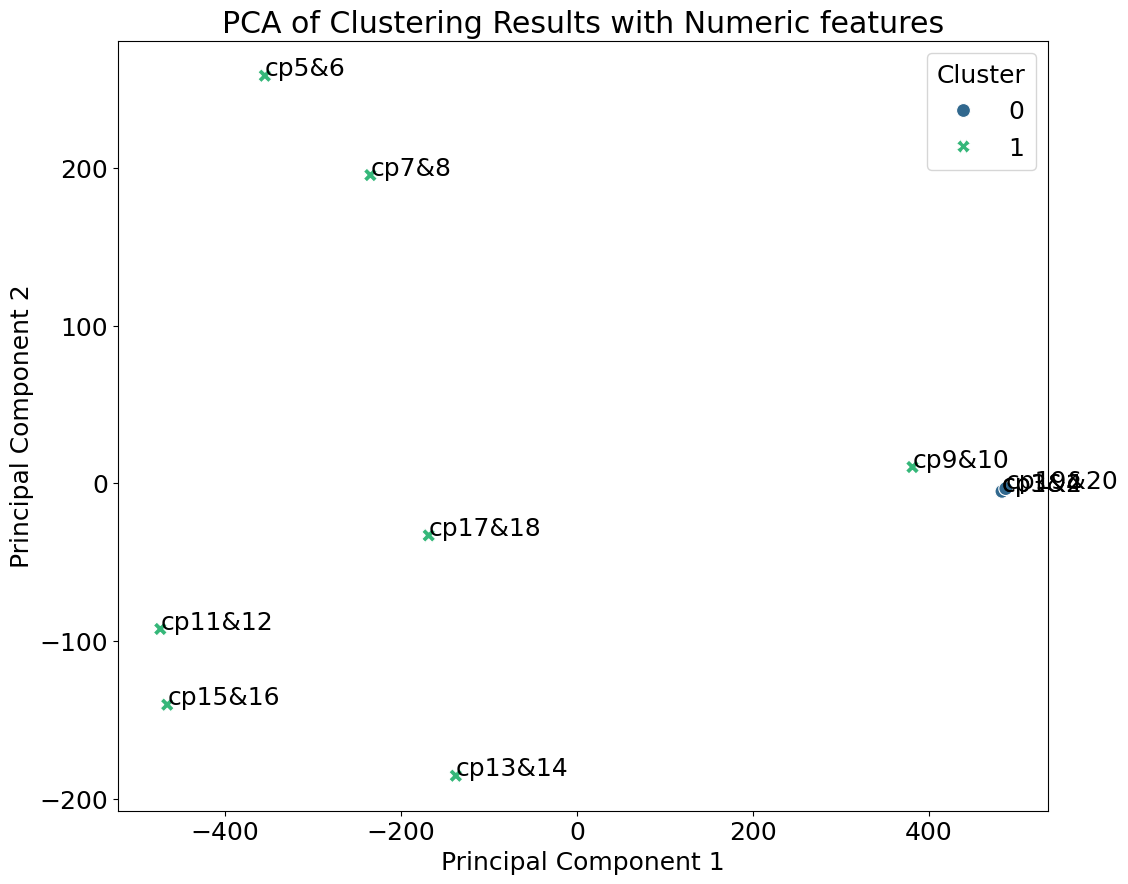

In [133]:
gtlabel = results_info['label'].values

pca = PCA(n_components=10)
features_pca = pca.fit_transform(data_clustering)


plt.figure(figsize=(12, 10))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=gtlabel, style=gtlabel, palette='viridis', s=100)

for i, text in enumerate(results_info['Compound Number']):  
    show_text = f"cp{text}"
    if i > 22:
        show_text = f"pos{text}"
    plt.annotate(show_text, (features_pca[i, 0], features_pca[i, 1]))

plt.title('PCA of Clustering Results with Numeric features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
# plt.savefig(save_name + '.png')
plt.show()

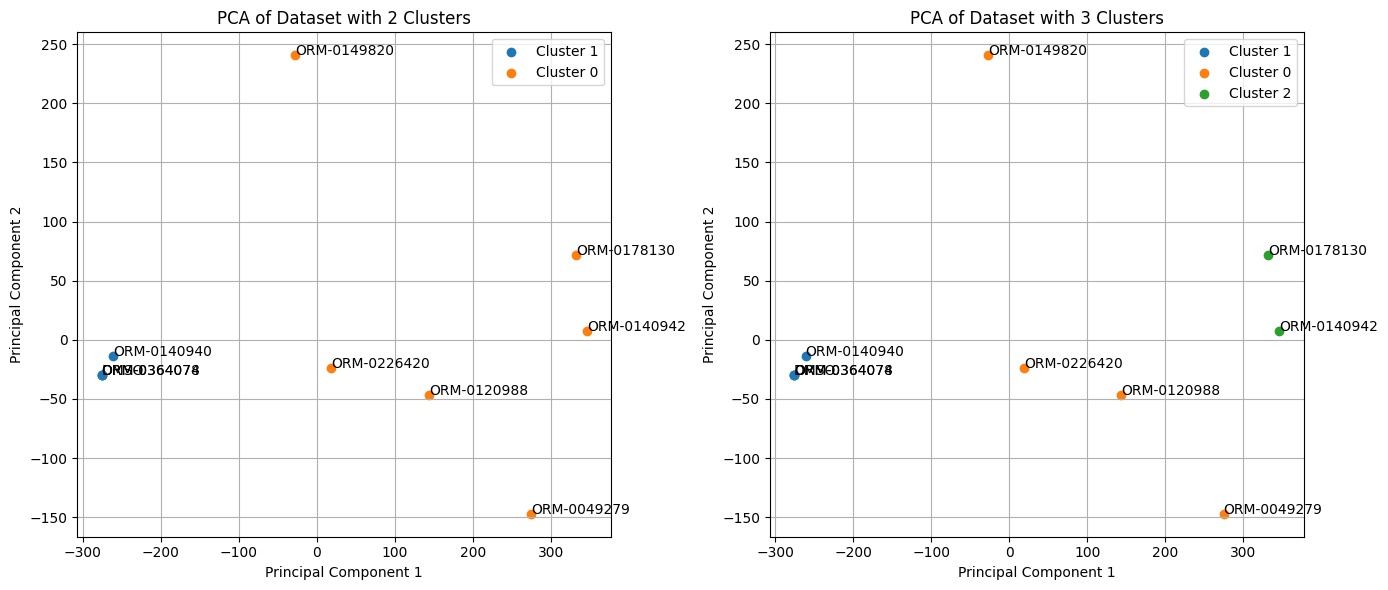

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA and reduce data dimensions to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_clustering)

# Create a DataFrame for easy plotting
plot_data = pd.DataFrame(data_pca, columns=['Principal Component 1', 'Principal Component 2'])
plot_data['Cluster_2'] = clusters_2
plot_data['Cluster_3'] = clusters_3
plot_data['Object Id'] = results_info['Object Id'].values
plot_data['Interpretation'] = results_info['Interpretation'].values

# Plotting the results of the 2 clusters
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 2 clusters
for cluster in plot_data['Cluster_2'].unique():
    subset = plot_data[plot_data['Cluster_2'] == cluster]
    ax[0].scatter(subset['Principal Component 1'], subset['Principal Component 2'], label=f'Cluster {cluster}')
    for i, txt in enumerate(subset['Object Id']):
        ax[0].annotate(txt, (subset['Principal Component 1'].iloc[i], subset['Principal Component 2'].iloc[i]))

ax[0].legend()
ax[0].grid(True)
ax[0].set_title('PCA of Dataset with 2 Clusters')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Plot for 3 clusters
for cluster in plot_data['Cluster_3'].unique():
    subset = plot_data[plot_data['Cluster_3'] == cluster]
    ax[1].scatter(subset['Principal Component 1'], subset['Principal Component 2'], label=f'Cluster {cluster}')
    for i, txt in enumerate(subset['Object Id']):
        ax[1].annotate(txt, (subset['Principal Component 1'].iloc[i], subset['Principal Component 2'].iloc[i]))

ax[1].legend()
ax[1].grid(True)
ax[1].set_title('PCA of Dataset with 3 Clusters')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()
